# Predicting Subscription Status Based on Experience Level, Age, and Hours Played 

#### Anthony Lu, Ashley Lee, and Guneet Kaur

In [287]:
library(tidyverse)
library(janitor)
library(tidymodels)

### Introduction

A study was conducted by a computer science group from UBC to try and understand how individuals play video games. Specifically, the game Minecraft was used to record play sessions through a server. Minecraft is a 3D open world video game made in 2009 and is played by people of a wide variety of ages (Hennginson, 2022). Because the play sessions were recorded, the number of hours played by each player was also observed in the study. Additionally, there are specific experience level classifications of players: Beginner, Amateur, Regular, Pro, and Veteran. Furthermore, within the game, there is a game-related newsletter which players can choose to subscribe to or not. From this data collected, the research group was able to form two datasets; one with information regarding players’ skill level and demographics and the other one with information about past play sessions. 

The research group posed three broad questions, of which this report aims to answer the first one: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter and how do these features differ between player types? This report chose to focus on a more specific question: Can experience level, hours played and age of a player predict whether or not they are subscribed to a game-related newsletter? For this question, k-nearest neighbours classification will be used because it aims to predict a known class/category for a new observation using quantitative explanatory variables from past observations. Regression will not be used because the prediction made is not a numerical/quantitative measurement. Classification is more appropriate in this case because the response variable is categorical: a player is either subscribed or not subscribed.
    
To answer this question, we use the players.csv dataset. This dataset has 7 columns/variables and 196 observations/rows, each being representative of a different player. It is useful because it provides specific information about players: the columns include experience level, if they are subscribed to the newsletter, hashed email, hours played, name, gender and age. Specifically for this project, the predictor variables (variable used to predict results) used are experience level, hours played and age and the response variable (variable predicted) is whether they are subscribed to the newsletter. 

#### Relevant Dataset
* players.csv. Let's read it in!

In [288]:
players_url <- "https://raw.githubusercontent.com/anthonyl8/video_game_server_usage/refs/heads/main/data/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Tidying the Data

Below, I've tidied the data by cleaning the column names, mutating character variable columns to become factor variable columns, and removing the two players with ages recorded as N/A. 



In [289]:
players <- players |>
    clean_names() |>
    mutate(experience = as_factor(experience), gender = as_factor(gender)) |>
    drop_na()

---
### Description of Tidied Data
* **Rows/Observations**: 194 (each represents a player)
* **Columns/Variables**: 7

**Categorical Variables:**
* experience (character): player's experience level on a scale of 5 categories
* subscribe (logical): whether a player is subscribed to a game-related newsletter or not
* hashed_email (character): player's email address in a hashed format
* name (character): player's first name
* gender (character): player's gender
  
**Quantitative Variables:**
* played_hours (double): number of hours played by player
* age (double): player's age
---

**Notes:**
* For our question, we'll need to mutate the values in the experience column to integers from 1 to 5. We are not given an ordering for the categories for experience level, but this report *assumes* the following order by skill level: Beginner, Amateur, Regular, Pro, Veteran. Thus, the values in the experience column will be mutated to become integers from 1 to 5, where 1 = Beginner and 5 = Veteran.
* Because subscribe is the response variable, it will also need to be mutated to become a factor variable.

This additional wrangling is handled below.

In [290]:
players <- players |>
    mutate(experience = as.integer(fct_recode(experience, "1" = "Beginner", "2" = "Amateur", "3" = "Regular", "4" = "Pro", "5" = "Veteran")), 
           subscribe = as_factor(subscribe))

Now, let's look at some summary statistics!

### Summary Statistics
* Mean and standard deviation for our explanatory variables (**hours_played**, **age**, and **experience**), which are quantitative
* Categorical frequencies for our response variable (**subscribe**), which is categorical

#### Hours Played:

In [291]:
players_summary_hours_played <- players |>
    summarize(avg_played_hours = mean(played_hours),
              sd_played_hours = sd(played_hours))
players_summary_hours_played

avg_played_hours,sd_played_hours
<dbl>,<dbl>
5.904639,28.49793


#### Age:

In [292]:
players_summary_age <- players |>
    summarize(avg_age = mean(age),
              sd_age = sd(age))
players_summary_age

avg_age,sd_age
<dbl>,<dbl>
20.52062,6.174667


#### Experience:

In [293]:
players_experience <- players |>
    count(experience) |>
    mutate(num_players = n) |>
    select(-n)
players_experience

experience,num_players
<int>,<int>
1,13
2,48
3,63
4,35
5,35


#### Subscribe:

In [294]:
players_subscribe <- players |>
    count(subscribe) |>
    mutate(num_players = n) |>
    mutate(proportion_of_players = num_players / 194) |>
    select(-n)
players_subscribe

subscribe,num_players,proportion_of_players
<fct>,<int>,<dbl>
FALSE,52,0.2680412
TRUE,142,0.7319588


#### Gender:

In [295]:
players_gender <- players |>
    count(gender) |>
    mutate(num_players = n) |>
    mutate(proportion_of_players = num_players / 194) |>
    select(-n)
players_gender

gender,num_players,proportion_of_players
<fct>,<int>,<dbl>
Male,124,0.63917526
Female,37,0.19072165
Non-binary,15,0.07731959
Prefer not to say,11,0.05670103
Agender,2,0.01030928
Two-Spirited,5,0.02577320


---
### Visualizations and Conclusions

Here are three visualizations, each of which compares one explanatory variable to the response variable (subscription status).

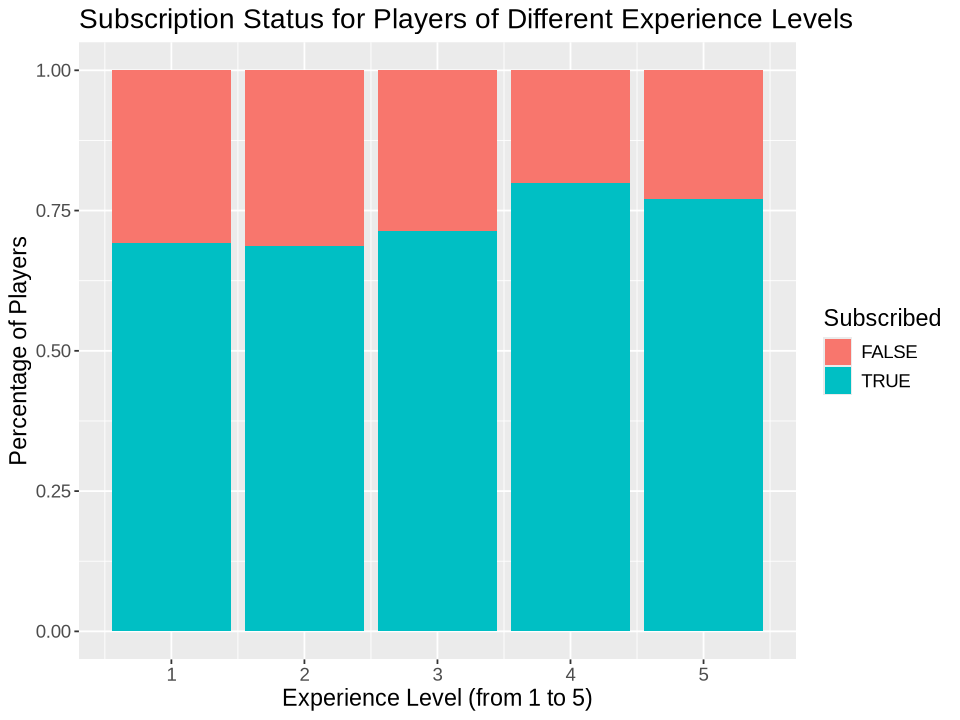

In [296]:
options(repr.plot.width = 8, repr.plot.height = 6)
players_experience_plot <- players |>
    ggplot(aes(x = experience)) +
    geom_bar(stat = "count", position = "fill", aes(fill = subscribe)) +
    xlab("Experience Level (from 1 to 5)") +
    ylab("Percentage of Players") +
    ggtitle("Subscription Status for Players of Different Experience Levels") +
    labs(fill = "Subscribed") +
    theme(text = element_text(size = 14))
players_experience_plot

#### Figure 1: Segmented bar chart showing relative frequencies of players' subscription statuses for each experience level

**Conclusion:** *Maybe* more experienced players are more likely to be subscribed?

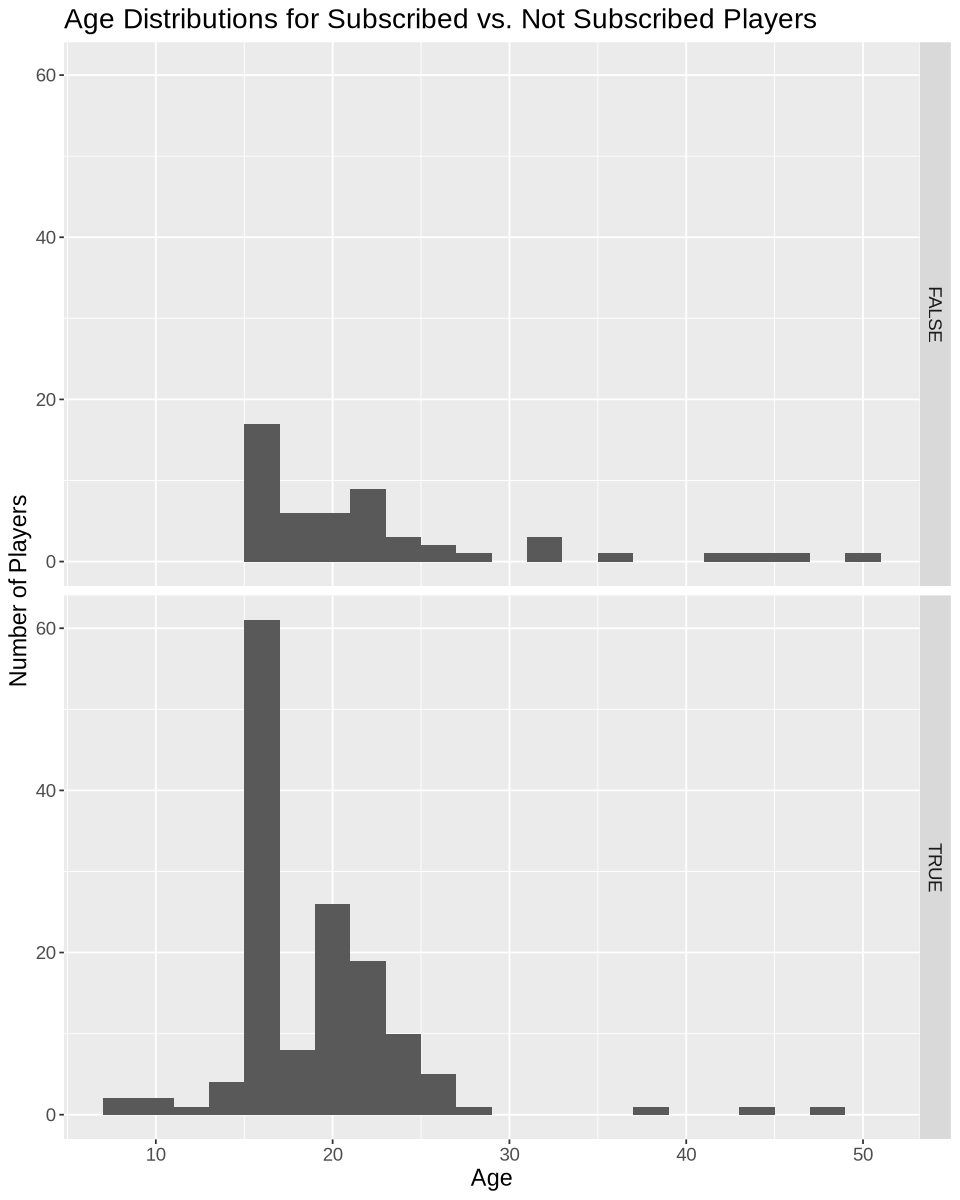

In [297]:
options(repr.plot.height = 10, repr.plot.width = 8)
players_age_plot <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 2) +
    facet_grid(rows = vars(subscribe)) +
    xlab("Age") +
    ylab("Number of Players") +
    ggtitle("Age Distributions for Subscribed vs. Not Subscribed Players") +
    theme(text = element_text(size = 14))
players_age_plot

#### Figure 2: Two histograms showing distributions of player ages for each subscription status

**Conclusion:** *Maybe* subscribed players are a bit more likely to be younger?

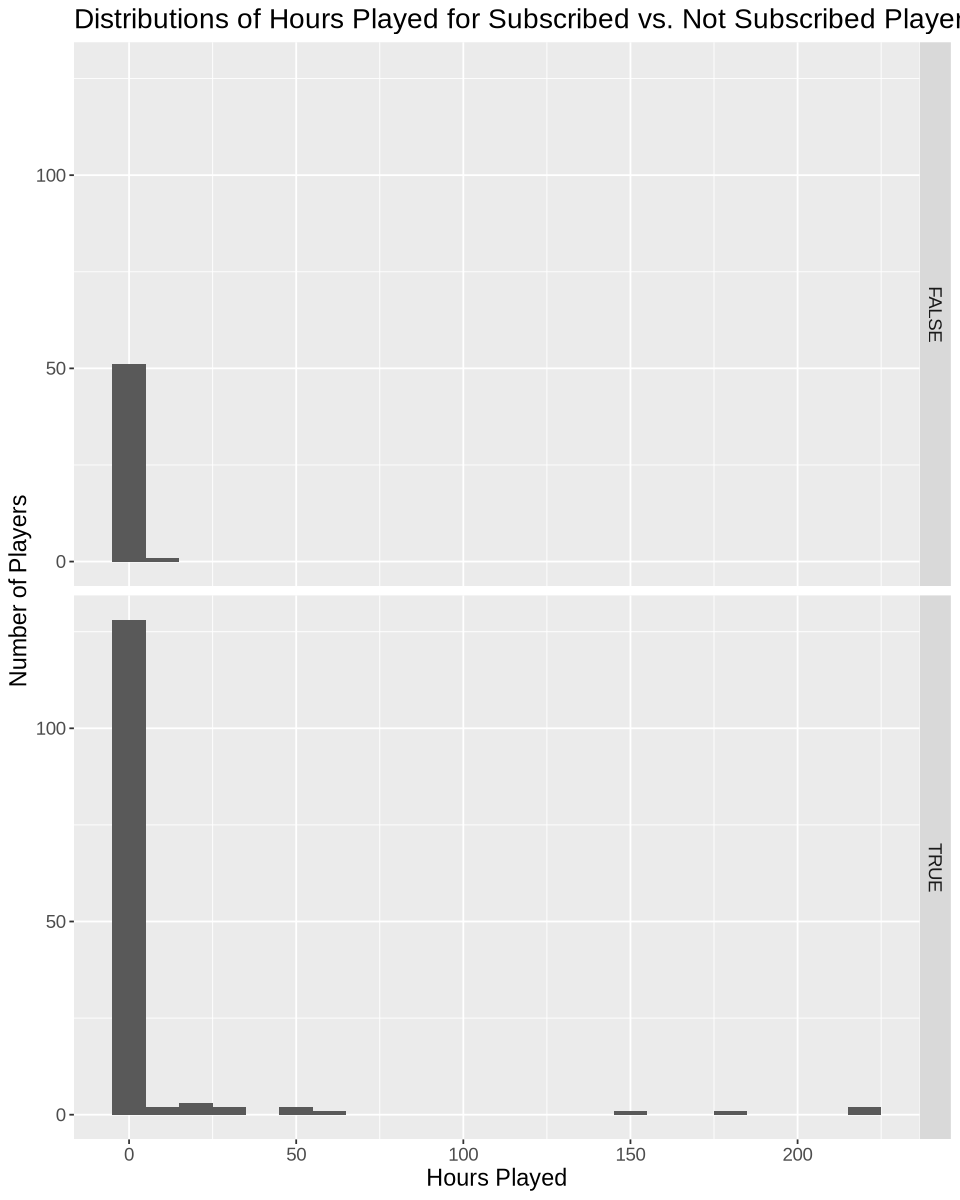

In [298]:
options(repr.plot.height = 10, repr.plot.width = 8)
players_played_hours_plot <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 10) +
    facet_grid(rows = vars(subscribe)) +
    xlab("Hours Played") +
    ylab("Number of Players") +
    ggtitle("Distributions of Hours Played for Subscribed vs. Not Subscribed Players") +
    theme(text = element_text(size = 14))
players_played_hours_plot

#### Figure 3: Two histograms showing distributions of hours played for each subscription status

**Conclusion**: It seems like players who've played for way more hours than most others are all subscribed.

All 3 predictor variables seem like they could be somehow correlated with subscription status, which validates the specific question posed by this report. However, all observed relationships also do not seem very strong, so further investigation will be necessary in order to draw more specific conclusions.

### Addressing the Question

This report will use k nearest neighbours classification, which is appropriate because I'm predicting a categorical variable using 3 quantitative predictor variables. This method requires few assumptions, which is good, but it may be sensitive to outliers.

Let's split the data into training and testing sets (at a 75/25 ratio) and stratify by subscription status.

In [299]:
set.seed(50)

players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
head(players_train)
head(players_test)

experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
3,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
3,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0.0,Quinlan,Male,22
3,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17
2,FALSE,f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea,0.0,Finn,Male,23
2,FALSE,951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd,0.1,Vivienne,Male,18
3,FALSE,df6a1201c9c638aff1df8aeaf459a5b0a00aa04824936ee0305f5c275352c647,0.0,Vasco,Prefer not to say,33


experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
2,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
2,TRUE,6f9acf8ea9956fe817895c78d10e1e25c11aba335a451e5b0322b073ee5008c4,0.0,Niamh,Non-binary,17
5,TRUE,9db37a1d381697f6c83e3b97b276e38bb9d9c811ba4596edb75d4dbfea6415b0,0.0,Elodie,Female,17
4,TRUE,bc704ff2bc676dbf48ee41b9e11481c1387bf758ad318f2428f336e3fecc6660,0.3,Andy,Male,8
5,TRUE,89c8e07d6a2aa102d9cd05086d51b2e41195c9c807dd976a06f4262ff36d0cca,0.0,Ren,Male,17
3,TRUE,119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,0.7,Hugo,Female,21


Let's create a recipe that uses experience, played_hours, and age as predictors, and scales and centers these predictors. Let's also make a model specification that tunes on the number of neighbours.

In [300]:
knn_tune <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune
players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
players_recipe

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Next, we'll perform a 5-fold cross-validation on the training set to determine the optimal k, creating a workflow analysis with the recipe and model specifications from above and trying k = 1 to 50.

In [301]:
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals)

Now, we'll collect the metrics from our workflow analysis and filter the metrics by accuracy.

In [302]:
knn_metrics <- knn_results |>
    collect_metrics()
accuracies <- knn_metrics |> 
      filter(.metric == "accuracy")
max_accuracy <- accuracies |>
    filter(mean == max(accuracies$mean))
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.7451888,5,0.01193642,Preprocessor1_Model13
14,accuracy,binary,0.7451888,5,0.01193642,Preprocessor1_Model14


Let's visualize the accuracy as k increases.

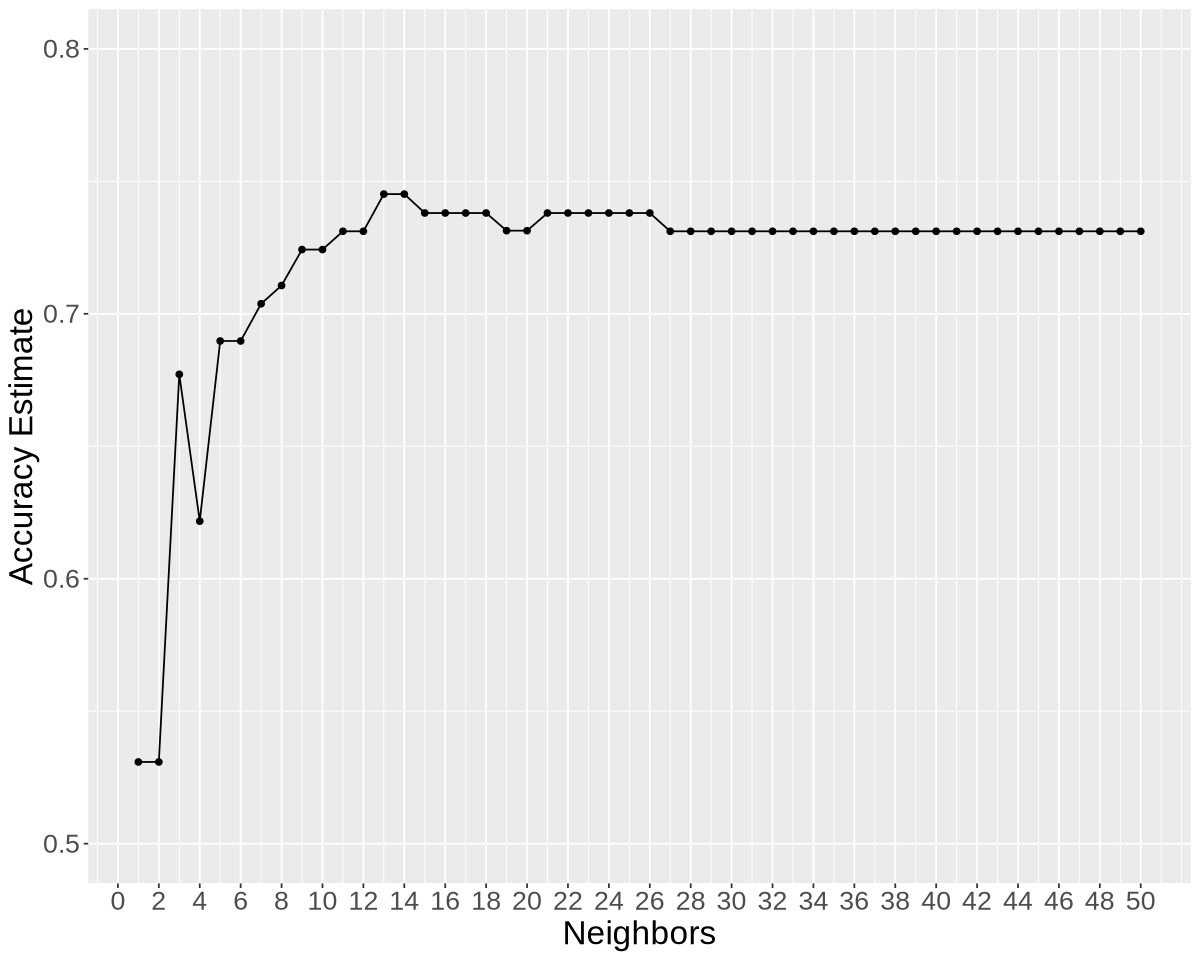

In [303]:
options(repr.plot.width = 10, repr.plot.height = 8)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 50, by = 2)) +
      scale_y_continuous(limits = c(0.5, 0.8)) +
      theme(text = element_text(size = 20))
accuracy_versus_k

#### Figure 4: Accuracy Estimate for Increasing Number of Neighbours

From Figure 4, it appears that k = 13 or 14 neighbours will give us the highest accuracy. We'll use k = 13 to create our final model.

Let's first create our model specification with our chosen optimal k (13).

In [304]:
knn_final_spec <- nearest_neighbor(weight = "rectangular", neighbors = 13) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_final_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 13
  weight_func = rectangular

Computational engine: kknn 


Now, let's create a workflow analysis using our new model specification, reusing the previous recipe specification, and passing in our training dataset.

In [305]:
knn_final_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_final_spec) |>
    fit(data = players_train)
knn_final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.262069
Best kernel: rectangular
Best k: 13

Next, we'll use this final model to make predictions on the testing dataset. Then, we'll determine the accuracy of these predictions and also show the confusion matrix.

In [306]:
knn_final_predictions <- predict(knn_final_fit, players_test) |>
    bind_cols(players_test)

knn_final_metrics <- knn_final_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

knn_final_conf_mat <- knn_final_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

knn_final_metrics
knn_final_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


          Truth
Prediction FALSE TRUE
     FALSE     0    2
     TRUE     13   34

The accuracy of the predictions on the testing dataset is around 0.694, which is not great. From the confusion matrix, we can see that our model seems to just predict that the vast majority of players are subscribed, with 47 positive predictions compared to just 2 negative predictions.

References 
Henningson, J. (2022, October 17). The History of Minecraft. Red Bull. https://www.redbull.com/se-en/history-of-minecraft